In [6]:
from app.db import connect
import pandas as pd
from sqlalchemy import bindparam, text, String, Date, Integer
import numpy as np

con = connect() 

topn = 10
fromdate = '2004-01-01'
todate = '2004-03-31'
stmt = text("SELECT * FROM topN_sold_products(:topn, :fromdate, :todate);")

stmt = stmt.bindparams(
                bindparam('topn', value=topn, type_=Integer),
                bindparam('fromdate', value=fromdate, type_=Date),
                bindparam('todate', value=todate, type_=Date)
            )

totalNSoldProd = pd.read_sql_query(stmt, con)

totalNSoldProd.to_csv('myCSV/totalNSoldProd.csv', index=False)

##############################################################
stmt = text("SELECT * FROM products_customers_by_date(:fromdate, :todate);")

stmt = stmt.bindparams(                
                bindparam('fromdate', value=fromdate, type_=Date),
                bindparam('todate', value=todate, type_=Date)
            )

prodCust = pd.read_sql_query(stmt, con)
con.close()

prodCust.to_csv('myCSV/ProductsCustomers.csv', index=False)
print("Filenames: totalNSoldProd.csv and ProductsCustomers.csv are created...")
con.close()


Connecting...
Filenames: totalNSoldProd.csv and ProductsCustomers.csv are created...


In [7]:
custprod = pd.read_csv('myCSV/ProductsCustomers.csv', index_col=["product_id"])
#custprod.head(45)

topNprods = pd.read_csv('myCSV/totalNSoldProd.csv')

topNprods = topNprods.set_index('product_id')
topNprods = pd.DataFrame(topNprods)
#topNprods.rename(columns = {'product_id':'prod_id'}, inplace = True)
topNprods

,category_name,title,totalamount_sold
product_id,,,
8306,Animation,ALABAMA FEATHERS,8
5000,Animation,AFRICAN ZORRO,7
1201,Action,ACE CYCLONE,7
5670,Children,AGENT PELICAN,7
2383,Comedy,ADAPTATION GROOVE,7
1698,Travel,ACE PRINCESS,7
1567,New,ACE MEET,7
6875,Drama,AIRPLANE TALENTED,7
1061,Animation,ACE BEAUTY,7


In [8]:
#result = pd.merge(topNprods, custprod, on='product_id')
#result = df.set_index('key').join(other.set_index('key'))
result = topNprods.join(custprod, on="product_id", how="inner")
cols = ["category_name","title","country","totalprice"]
result = result.loc[:, cols]
result = result[(result["totalprice"] >= 20.0) & (result["totalprice"] <= 60.0)]
result


,category_name,title,country,totalprice
product_id,,,,
8306,Animation,ALABAMA FEATHERS,US,39.98
8306,Animation,ALABAMA FEATHERS,US,59.97
8306,Animation,ALABAMA FEATHERS,France,39.98
8306,Animation,ALABAMA FEATHERS,China,39.98
8306,Animation,ALABAMA FEATHERS,Russia,59.97
8306,Animation,ALABAMA FEATHERS,South Africa,39.98
5000,Animation,AFRICAN ZORRO,US,47.97
5000,Animation,AFRICAN ZORRO,US,47.97
5000,Animation,AFRICAN ZORRO,US,47.97


In [9]:
grouped_res = result["totalprice"].groupby([result["country"],result["category_name"]])
final = pd.DataFrame(grouped_res.sum())
cols = ["Australia","UK","US"]
final = final.loc[cols]

final

totalprice
country   category_name            
Australia Action              25.99
          Animation           31.98
          Comedy              53.98
UK        Action              51.98
          Children            41.97
US        Action              77.97
          Animation          539.74
          Children            41.97
          Comedy             161.94
          New                129.95
          Travel             115.96

In [10]:
grouped_countries = final["totalprice"].groupby("country")
agregates = [np.sum, np.mean]
grouped_countries = grouped_countries.agg(agregates)
grouped_countries.columns = ["sum", "average"]
grouped_cat = final.groupby("category_name")["totalprice"]
grouped_cat = grouped_cat.agg(agregates)
grouped_cat.columns = ["sum", "average"]

grouped_cat,  grouped_countries

(                  sum  average
 category_name                 
 Action         155.94    51.98
 Animation      571.72   285.86
 Children        83.94    41.97
 Comedy         215.92   107.96
 New            129.95   129.95
 Travel         115.96   115.96,
                sum     average
 country                       
 Australia   111.95   37.316667
 UK           93.95   46.975000
 US         1067.53  177.921667)

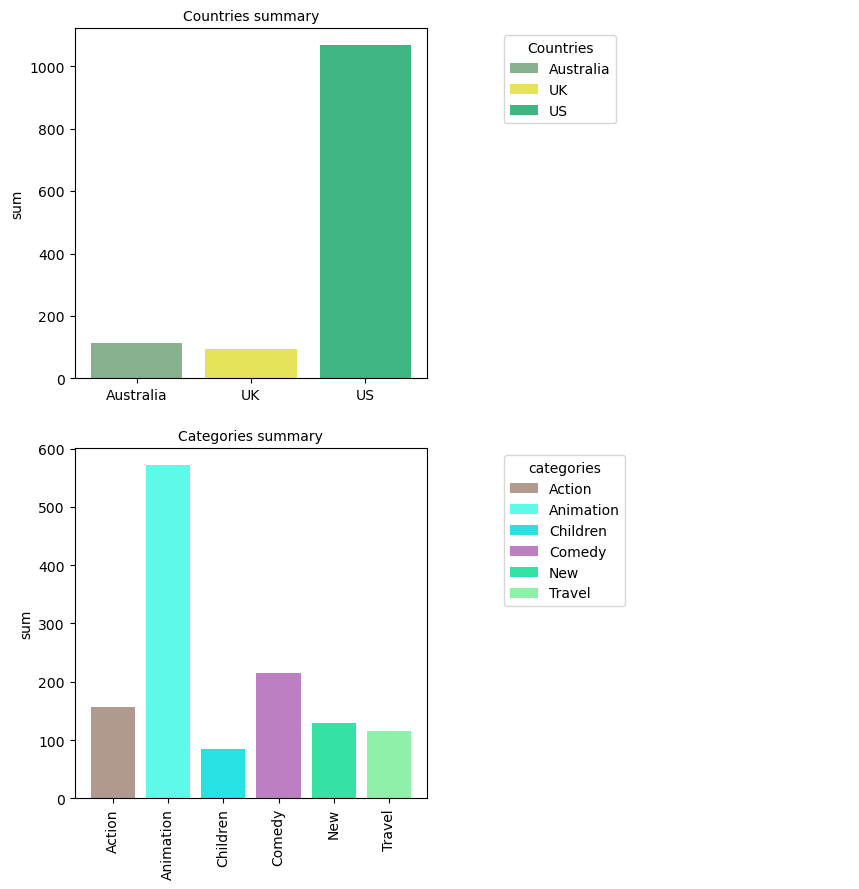

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random

N1 = len(grouped_countries)
N2 = len(grouped_cat)

f = plt.figure()
f = plt.gcf()
f.set_size_inches(10,10)

ax1 = f.add_subplot(2,2,1)
ax2 = f.add_subplot(2,2,3)
ax1_legend = f.add_subplot(2,2,2)
ax2_legend = f.add_subplot(2,2,4)

def get_results(length, sub_plot, dataset, colname, angle):
    
    hexa = '0123456789ABCDEF'

    colors = ["#" + ''.join([random.choice(hexa) for j in range(6)]) for i in range(length)]

    x = np.arange(length).astype(int)
    y = np.array(dataset[colname])
    idxCol = np.array(dataset.index)

    sub_plot.bar(x, y)
    for i,p in enumerate(sub_plot.patches):
        p.set_facecolor(colors[i])    
        p.set_label(idxCol[i])  
        
    handles, labels = sub_plot.get_legend_handles_labels()  
    
    sub_plot.set_xticks(x, np.array(dataset.index), rotation=angle)
    return sub_plot, handles, labels

if __name__ == "__main__":
    ax1, handles1, labels1 = get_results(N1, ax1, grouped_countries, "sum", 0)
    ax1.set_ylabel("sum")
    ax2, handles2, labels2 = get_results(N2, ax2, grouped_cat, "sum", 90)    
    ax2.set_ylabel("sum")
    
    #ax1.legend()
    ax1_legend.axis(False)
    ax1_legend.legend(handles1, labels1, title="Countries", loc="upper left")
    ax2_legend.axis(False)
    ax2_legend.legend(handles2, labels2, title="categories", loc="upper left")
    ax1.set_title('Countries summary', fontsize=10)
    ax2.set_title('Categories summary', fontsize=10)    

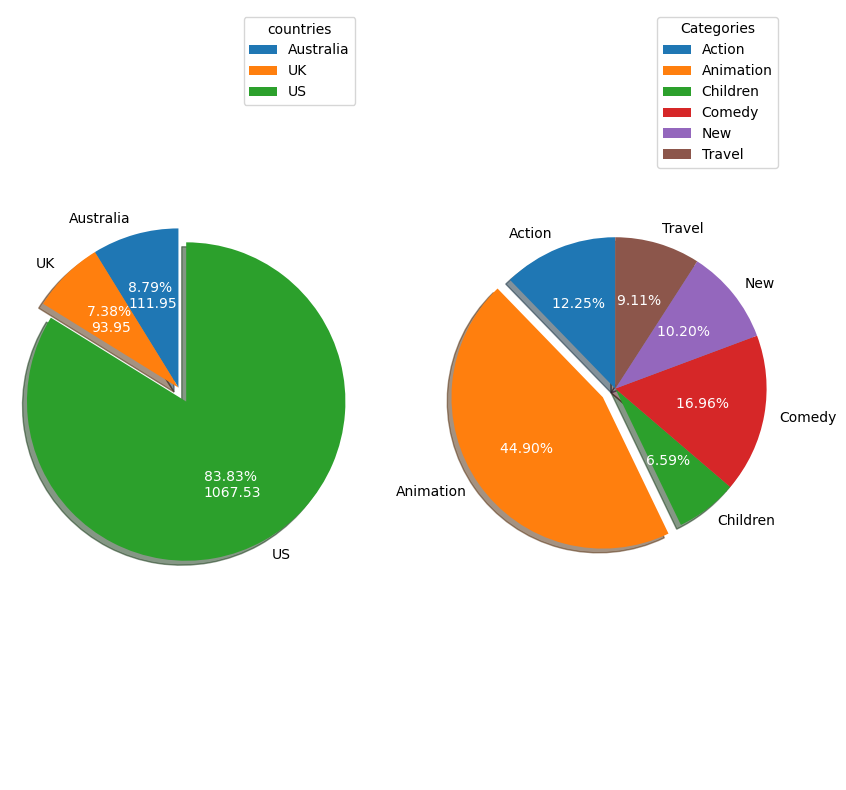

In [14]:
f1 = plt.figure()
ax1 = f1.add_subplot(1,2,1)
ax2 = f1.add_subplot(1,2,2)
f1 = plt.gcf()
f1.set_size_inches(10,10)

def get_pie(length, dataset, colname, originaldata, titles, sub_plot):
    ind = np.argmax(np.array(dataset[colname]))

    expl = [0.1 if i==ind else 0. for i in range(length) ]
    
    if originaldata:
        data = lambda p:f'{p:.2f}% \n{p*sum(np.array(dataset[colname]))/100 :.2f}'
    else:
        data = lambda p:f'{p:.2f}% '

    r, t, u = sub_plot.pie(np.array(dataset[colname]), explode=expl,labels=dataset.index, 
                  autopct=data, 
                  shadow=True, startangle=90)
    sub_plot.legend(r, dataset.index, title=titles, loc="best")
    # Equal aspect ratio ensures that pie is drawn as a circle.
    sub_plot.axis('equal')

    plt.setp(u, color='white')
    
if __name__ == "__main__":    
    a1 = get_pie(N1, grouped_countries, "sum", True, "countries", ax1)
    a2 = get_pie(N2, grouped_cat, "sum", False, "Categories", ax2)
    plt.show()
    f1.savefig(fname="myCSV/figpath1.pdf", dpi=400, format="pdf")

TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

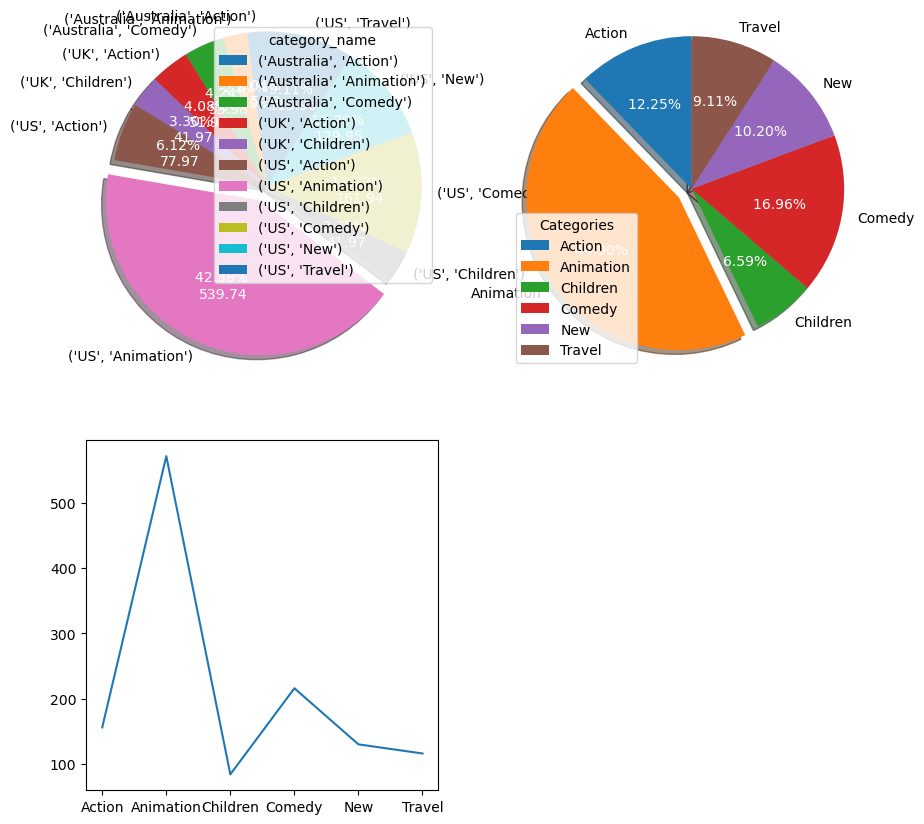

In [22]:
f1 = plt.figure()
ax1 = f1.add_subplot(2,2,1)
ax2 = f1.add_subplot(2,2,2)
ax3 = f1.add_subplot(2,2,3)
f1 = plt.gcf()
f1.set_size_inches(10,10)

N1 = len(final)

def get_pie(length, dataset, colname, originaldata, titles, sub_plot):
    ind = np.argmax(np.array(dataset[colname]))

    expl = [0.1 if i==ind else 0. for i in range(length) ]
    
    if originaldata:
        data = lambda p:f'{p:.2f}% \n{p*sum(np.array(dataset[colname]))/100 :.2f}'
    else:
        data = lambda p:f'{p:.2f}% '

    r, t, u = sub_plot.pie(np.array(dataset[colname]), explode=expl,labels=dataset.index, 
                  autopct=data, 
                  shadow=True, startangle=90)
    sub_plot.legend(r, dataset.index, title=titles, loc="best")
    # Equal aspect ratio ensures that pie is drawn as a circle.
    sub_plot.axis('equal')

    plt.setp(u, color='white')
    
if __name__ == "__main__":    
    a1 = get_pie(N1, final, "totalprice", True, "category_name", ax1)
    a2 = get_pie(N2, grouped_cat, "sum", False, "Categories", ax2)
    x1 = grouped_cat.index
    y1 = grouped_cat["sum"]
    ax3.plot(x1,y1)
    ax3.set_xticks(rotation=90)
    plt.show()
    f1.savefig(fname="myCSV/figpath1.pdf", dpi=400, format="pdf")